### Data Preparation for Enterotype Analysis

- **Preprocessing Directory**  
  The final rarefied feature table was generated in the `Step1_Microbiome_Raw_data_preprocessing_Qiime_0h`.

- **CSV Conversion**  
  This `.tsv` file was converted to `rarefied_yoo_0h_16.csv` for compatibility with subsequent analysis steps.

- **Input Format for `MetagenomeAnalysis`**  
  The `rarefied_yoo_0h_16.csv` file serves as the input for the `MetagenomeAnalysis` class.  
  The structure of this file—columns representing samples and rows representing taxa—follows the required format for class initialization.


### Exploratory Data Analysis

- The data analyzed in the Jupyter notebook was saved to the `Enterotype_summary.xlsx` file for further use.
- This file (`Enterotype_summary.xlsx` ) was later used in the `Enterotyping_Figure1.ipynb` notebook to regenerate the final visualization.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from libs.metagenome import MetagenomeAalysis, MetagenomeFigure
from libs.utils_distance import calculate_distance
from libs.utils import cluster_sorting
from libs.utils import nth_largest_feature

from skbio.stats.ordination import pcoa


# you are trying to run a Mach-O file (which is an executable file format used by macOS) that is built for the x86_64 architecture on a system that requires an ARM architecture (
from libs.utils_preprocessing import *
from libs.utils_figure import *
from libs.utils_distance import *

In [ ]:
meta_analysis = MetagenomeAalysis('./data/rarefied_yoo_0h_l6.csv', sep=',', is_relative=False, is_taxa_file=False)

df_raw = meta_analysis.df_raw 
df = meta_analysis.df_taxa_sorted  # Features with all zero values have been removed
df_top_20 = meta_analysis.feature_selection(20) # Select top 20 features based on total intensity
df_001_remove = meta_analysis.feature_remove_percent(percent=0.01) # Remove features whose total intensity is less than 0.01% of the overall sum


# shape = (numbers of sample, numbers of features) / 
print(df_raw.shape) # Original input file. Note: df_raw has no index set, so format is (samples, features + 1)
print(df.shape) # After removing features with all zero values
print(df_top_20.shape) # After selecting top 20 features by intensity + 1 feature labeled as "Others"
print(df_001_remove.shape) # After removing features whose total intensity is less than 0.01% of the total sum

original data shape: (18, 152)
returned data shape: (18, 152)
(18, 153)
(18, 152)
(18, 21)
(18, 116)


In [4]:
df.to_csv('./output/enterotype_yoo_0h_level6_taxa.csv')
df_top_20.to_csv('./output/enterotype_yoo_0h_level6_taxa_top20.csv')

In [ ]:
# Distance matrix
# Constructed following the method described on https://enterotype.embl.de/enterotypes.html
# The `calculate_distance` function uses Jensen-Shannon Divergence (JSD); its use is recommended

dist_matrix = calculate_distance(df, 'jensen', pesudocount=0.000001)
dist_matrix.to_csv('./output/enterotype_yoo_0h_jesen_distance.csv')
dist_matrix.shape # (sample, sample)

(18, 18)

In [ ]:
# Clustering
# The input is a preprocessed DataFrame (e.g., `df` from the MetagenomeAnalysis class)
# This implementation follows the method described on https://enterotype.embl.de/enterotypes.html

meta_figure = MetagenomeFigure(df=df) 

In [ ]:
# Partitioning Around Medoids (PAM) clustering algorithm
# Initial exploratory step to determine the optimal number of clusters (k)

# nclusters_ch = Number of clusters determined by Calinski-Harabasz (CH) index
# nclusters_sil = Number of clusters determined by silhouette validation

# If an error occurs, import the `pam_clustering_eda` function directly into the notebook and run it manually.
# In some cases, the cell needs to be run twice for successful execution.
# If the result seems off or an error occurs, re-run the cell once more.
# (The cause of the conflict is unknown.)

nclusters_ch, nclusters_sil = meta_figure.pam_clustering_eda(dist_matrix)

Calinski-Harabasz Index for different cluster numbers:
k=2: CH Index=42.455512986399654
k=3: CH Index=22.77542943634821
k=4: CH Index=15.824756757149268
k=5: CH Index=11.7860534662762
k=6: CH Index=10.184588159242775
k=7: CH Index=10.435105215510296
k=8: CH Index=8.325171825509319
k=9: CH Index=8.71435437229182
k=10: CH Index=12.096584727173228
k=11: CH Index=14.507894471966635
k=12: CH Index=14.055035093838296
k=13: CH Index=12.803584696568207
k=14: CH Index=16.77613242634148
k=15: CH Index=18.842487839178663
k=16: CH Index=18.593636315684673
k=17: CH Index=30.659053116985458


In [10]:
data_dict = {'nclusters_ch': nclusters_ch, 'nclusters_sil': nclusters_sil}
data_dict = pd.DataFrame(data_dict)

data_dict.to_csv('./output/enterotype_clustering_ncluster_ch_sil.csv', index=False)

In [11]:
data_dict.head(3)

,nclusters_ch,nclusters_sil
0,NaN,NaN
1,42.455513,0.593112
2,22.775429,0.212305


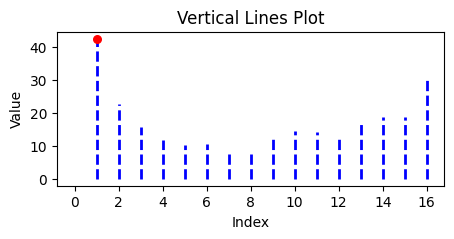

In [ ]:
plot_vertical(nclusters_ch, figsize=(5, 2))

In [ ]:
labels, clusters = meta_figure.pam_clustering_k(dist_matrix, k=2)

print(labels)
print(clusters)

[0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1]
[[0, 1, 2, 3, 4, 5, 6, 7, 10, 13, 14, 16], [8, 9, 11, 12, 15, 17]]


In [14]:
data_dict = {'labels' : labels}
data_dict = pd.DataFrame(data_dict)

data_dict.to_csv('./output/enterotype_clustering_labels.csv', index=False)


/Users/jinwookim/Documents/workspace/논문/250526_유혜빈/4_Enterotype_data_analysis_240730 복사본/libs/metagenome.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.2f}%)')
/Users/jinwookim/Documents/workspace/논문/250526_유혜빈/4_Enterotype_data_analysis_240730 복사본/libs/metagenome.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.2f}%)')


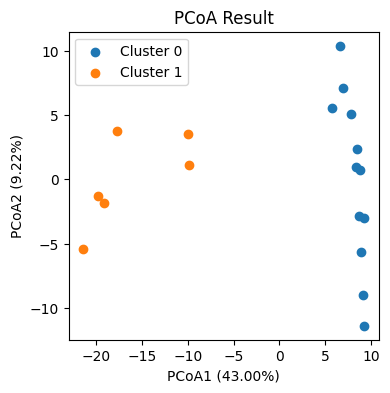

In [ ]:
pcoa_results = meta_figure.get_pcoa_figure(dist_matrix, labels=labels)

In [16]:
pcoa_results = pcoa(dist_matrix)
pcoa_df = pcoa_results.samples

pcoa_df.to_csv('./output/enterotype_pcoa_results.csv', index=False)

/var/folders/89/r90clckn1_gd94jtjjw57zww0000gn/T/ipykernel_48786/3829688015.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


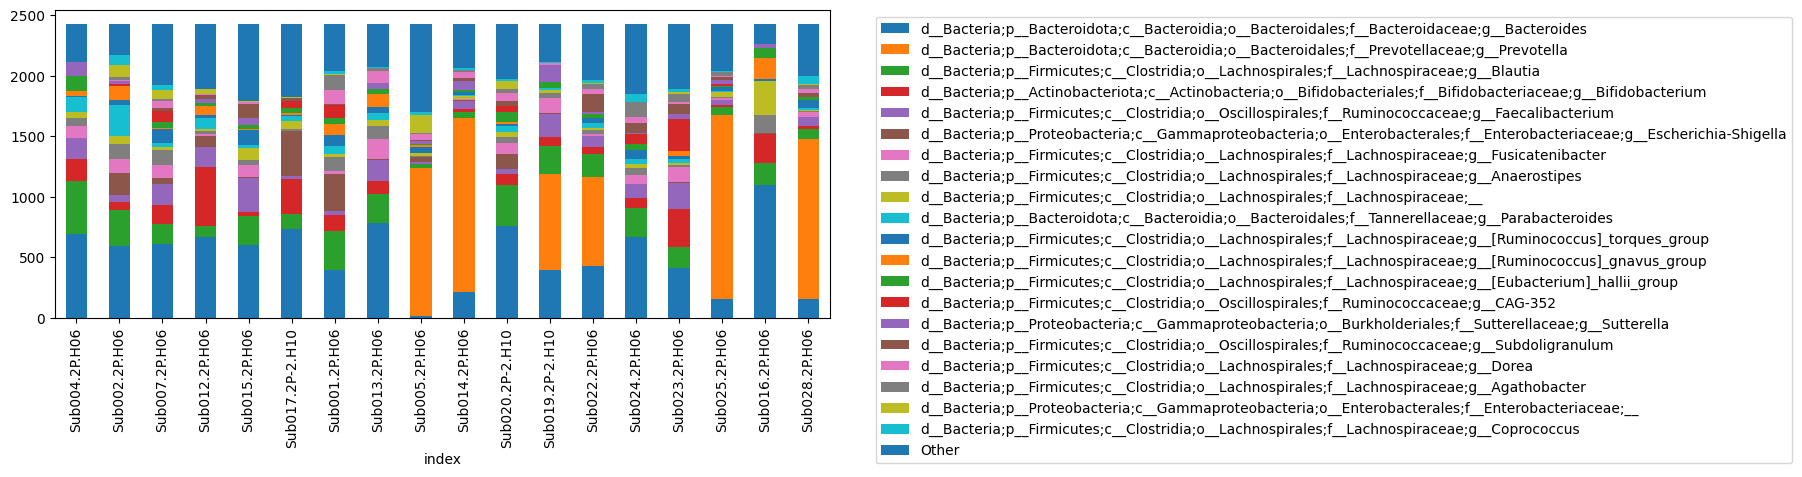

In [18]:
# print(sample_names)
# df_top_sort, df_top_sort_raw, cluster_dict = cluster_sorting(df_top_20, labels)

df_top_20.plot(kind='bar', stacked=True, figsize=(10, 4))
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [ ]:
# Identify the most dominant feature (excluding "Others")

df_top_sort_rev = df_top_20.drop(columns='Other')
top_genus = nth_largest_feature(df_top_sort_rev, 1)
top_genus


index
Sub004.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub002.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub007.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub012.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub015.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub017.2P-2.H10    d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub001.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub013.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub005.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub014.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub020.2P-2.H10    d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub019.2P-2.H10    d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub022.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub024.2P.H06      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
Sub023.2P.H06      d__Bacter

In [20]:
top_genus.to_csv('./output/top_genus_sample.csv')